$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Wet Assignment
<a id=part1></a>

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# CIFAR10
<a id=part2_2></a>

#### Loading the data

Using device: cuda
Train size: 47128
Validation size: 15710
Test size: 15710


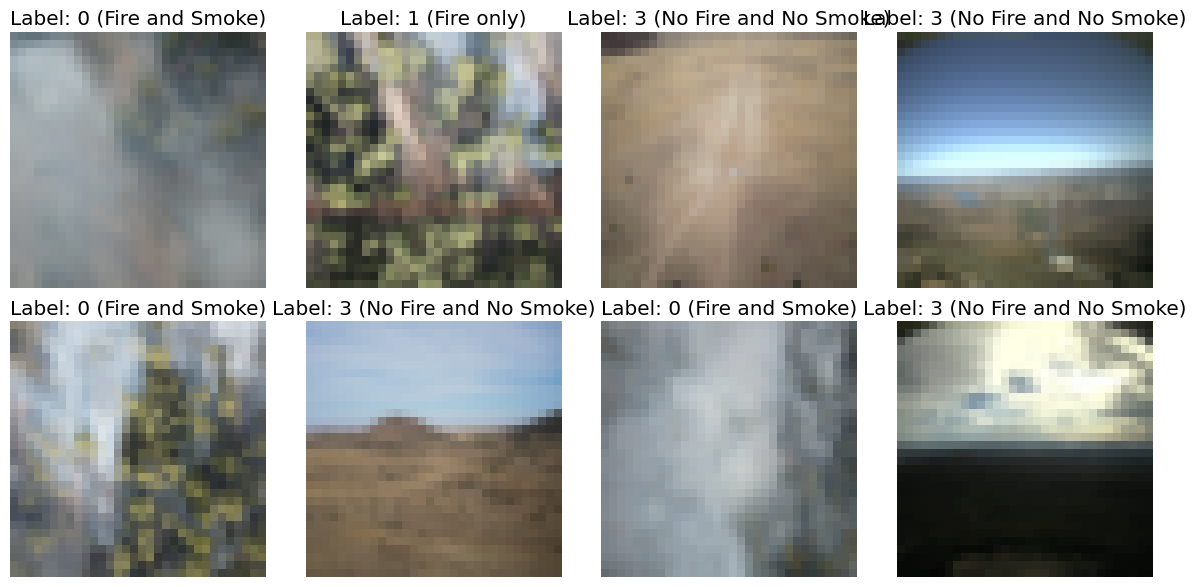

In [3]:
import os
import pandas as pd
import torch
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

image_size=32

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Load and prepare data from Excel
def load_image_label_data(images_dir, labels_excel_path):
    df = pd.read_csv(labels_excel_path)

    # Drop rows with missing fire or smoke labels
    df = df.dropna(subset=['fire', 'smoke'])

    # Ensure values are integers
    df['fire'] = df['fire'].astype(int)
    df['smoke'] = df['smoke'].astype(int)

    # Map labels to 0–3
    def map_label(row):
        if row['fire'] == 1 and row['smoke'] == 1:
            return 0
        elif row['fire'] == 1 and row['smoke'] == 0:
            return 1
        elif row['fire'] == 0 and row['smoke'] == 1:
            return 2
        else:
            return 3

    df['label'] = df.apply(map_label, axis=1)

    # Generate full image paths
    df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, x))

    # Filter out missing files
    df = df[df['image_path'].apply(os.path.exists)]

    image_paths = df['image_path'].tolist()
    labels = df['label'].tolist()
    return image_paths, labels

# Custom dataset from pre-split lists
class FireSmokeDatasetFromLists(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Visualization utility
def show_examples(dataset, num_images=8):
    label_names = {
        0: "Fire and Smoke",
        1: "Fire only",
        2: "Smoke only",
        3: "No Fire and No Smoke"
    }

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img, label = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label} ({label_names[label]})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Paths (replace with actual paths)
images_dir = 'Datasets_FromDvir/Datasets/rgb_images'
labels_excel_path = 'Datasets_FromDvir/Datasets/labels.csv'

# Load data
image_paths, labels = load_image_label_data(images_dir, labels_excel_path)

# Stratified split: train (60%), validation (20%), test (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Create datasets
train_dataset = FireSmokeDatasetFromLists(train_paths, train_labels, transform=transform)
val_dataset = FireSmokeDatasetFromLists(val_paths, val_labels, transform=transform)
test_dataset = FireSmokeDatasetFromLists(test_paths, test_labels, transform=transform)

# Create DataLoaders
batch_size = 128*2
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# Print sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Optional: show example images
show_examples(train_dataset)


In [4]:
##### בדיקות

import pandas as pd

df = pd.read_csv('Datasets_FromDvir/Datasets/labels.csv')
print(df.head())
print(df.columns)

#####
for i in range(len(train_dataset)):
    try:
        img, label = train_dataset[i]
        if i < 5:
            print(f"Sample {i}: Image shape = {img.shape}, Label = {label}")
    except Exception as e:
        print(f"Error at index {i}: {e}")

#####
from PIL import Image
import os

# Assuming you use train_dataset built from image_paths and labels
bad_images = []

print("Checking image integrity...")
for i, (path, label) in enumerate(zip(test_dataset.image_paths, test_dataset.labels)):
    if i%500==0:
        print(i)
        
    if not os.path.exists(path):
        print(f"Missing file: {path}")
        bad_images.append(path)
        continue

    try:
        img = Image.open(path)
        img.verify()  # Only verifies image is readable, without loading into memory
    except Exception as e:
        print(f"Corrupt image: {path} — {e}")
        bad_images.append(path)

print(f"Found {len(bad_images)} bad images.")


              id              dataset  fire  smoke thermal_id
0  fire_0001.jpg  Forest Fire Dataset     1    NaN        NaN
1  fire_0002.jpg  Forest Fire Dataset     1    NaN        NaN
2  fire_0003.jpg  Forest Fire Dataset     1    NaN        NaN
3  fire_0004.jpg  Forest Fire Dataset     1    NaN        NaN
4  fire_0005.jpg  Forest Fire Dataset     1    NaN        NaN
Index(['id', 'dataset', 'fire', 'smoke', 'thermal_id'], dtype='object')


## Classification-Guided Encoding
<a id=part2_2></a>

#### Training the model

In [5]:
import torch.nn as nn
import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, random_split
# import torchvision.transforms as tvtf

# from functions.autoencoder import AutoencoderCIFAR10
# from functions.plot import plot_fit


# from torch.utils.data import DataLoader, random_split
# from torchvision import datasets, transforms
# from torch.utils.data import Dataset
# from PIL import Image
# import random


from functions.autoencoder import AutoencoderCIFAR10
from functions.training import ClassificationGuidedEncoding
from functions.Classifier import AutoencoderClassifier, ClassifierCifar
from functions.plot import plot_fit

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize Model, Loss, and Optimizer
latent_dim = 8
# autoencoder = AutoencoderCIFAR10(latent_dim=latent_dim).to(device)
autoencoder = AutoencoderCIFAR10(input_size=(3, image_size, image_size), latent_dim=latent_dim).to(device)
classifier_org = ClassifierCifar(input_dim=latent_dim, num_classes=4).to(device)
classifier = AutoencoderClassifier(autoencoder, classifier_org).to(device)

loss_fn = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=1e-4)

# Initialize Trainer
trainer = ClassificationGuidedEncoding(classifier, loss_fn, optimizer, device)


cuda


In [5]:
##### בדיקות

print("Trying to load one batch...")
x, y = next(iter(train_loader))
print("Loaded batch:", x.shape, y.shape)

#####
print("Testing single batch training...")
batch = next(iter(train_loader))
res = trainer.train_batch(batch)
print("Single batch train result:", res)

#####
dummy = torch.zeros(1, 3, 32, 32)
latent = autoencoder(dummy.to(device))
print("Latent shape:", latent.shape)


Trying to load one batch...
Loaded batch: torch.Size([128, 3, 32, 32]) torch.Size([128])


In [ ]:

# Train the Model
fig_optim = None
fit_res = trainer.fit(train_loader, val_loader, test_loader, num_epochs=50, checkpoints="autoencoderclassifier_cifar10",
                      early_stopping=55, print_every=5, max_batches_per_epoch=50)
fig, axes = plot_fit(fit_res, fig=fig_optim)

print("Training Complete! Model saved at autoencoderclassifier_cifar10.pt")

Start training
0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# הגדרת המכשיר
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# הגדרת מודל פשוט
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 224 * 224, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
).to(device)

# הגדרת פונקציית הפסד ואופטימיזר
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# יצירת דאטה רנדומלי
batch_size = 128
x = torch.randn(batch_size, 3, 224, 224).to(device)  # תמונות רנדומליות
y = torch.randint(0, 10, (batch_size,)).to(device)   # תוויות רנדומליות

# אימון של כמה איטרציות
print("Starting test training...")
for i in range(100):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")


Using device: cuda
Starting test training...
Step 0, Loss: 2.3445
Step 10, Loss: 0.0000
Step 20, Loss: 0.0000
Step 30, Loss: 0.0000
Step 40, Loss: 0.0000
Step 50, Loss: 0.0000
Step 60, Loss: 0.0000
Step 70, Loss: 0.0000
Step 80, Loss: 0.0000
Step 90, Loss: 0.0000


In [11]:
checkpoint = torch.load("autoencoderclassifier_cifar10.pt")
best_acc = checkpoint['best_acc']
print(f"Best Accuracy: {best_acc}%")

Best Accuracy: 91.27232528974226%


####  t-SNE projections plotting

In [8]:
from functions.utils import plot_tsne

classifier.eval()  # Set to evaluation mode
        
# Extract the encoder
encoder = classifier.autoencoder.encoder  # Extract encoder only
encoder.to(device)

encoder_name = 'autoencoderclassifier_cifar10'
plot_tsne(encoder, test_loader, encoder_name, device)

ValueError: perplexity must be less than n_samples

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as tvtf

from functions.autoencoder import AutoencoderCIFAR10
from functions.plot import plot_fit


from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import random

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Define the custom dataset class for loading the images
class FireDataset(Dataset):
    def __init__(self, fire_dir, no_fire_dir, transform=None):
        self.fire_images = self._load_images(fire_dir)
        self.no_fire_images = self._load_images(no_fire_dir)
        self.transform = transform
        
        # Combine both lists of images
        self.images = self.fire_images + self.no_fire_images
        self.labels = [1] * len(self.fire_images) + [0] * len(self.no_fire_images)
    
    def _load_images(self, folder):
        images = []
        for file_name in os.listdir(folder):
            if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust the extensions as needed
                images.append(os.path.join(folder, file_name))
        return images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Directories for your images
fire_dir = '100Photos_Dataset/Flame with Smoke'
no_fire_dir = '100Photos_Dataset/No Flame No Smoke'

# Define the transformation to apply to images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust to the input size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for RGB images
])

# Create the dataset
dataset = FireDataset(fire_dir, no_fire_dir, transform=transform)

# Set the subset rate and split ratio (80% train, 20% validation)
subset_rate = 1.0  # Set to 1.0 to use the full dataset, or reduce for a smaller subset
train_size = int(subset_rate * len(dataset) * 0.4)
val_size = int(subset_rate * len(dataset) * 0.4)
test_size = len(dataset) - train_size - val_size

# Split dataset into train, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader setup
batch_size = 12
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, prefetch_factor=2)

# Check the lengths of each dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


cuda
Train dataset size: 28
Validation dataset size: 28
Test dataset size: 14
